In [35]:
from galileojp.frames import ExperimentFrameGateway
from galileojp.external import concurrent_req_log_as_df
from galileojp.widgets import experiment_dropdown
import matplotlib.pyplot as plt
import pandas as pd
import os

# Todo:
#  - join on telemetry data (round to second)
#  - join on concurrency data
#  - join on weight data

columns = ['name', 'concurrent_requests', 'mean', 'stdev', 'median', 'q25', 'q75', 'q90', 'q99']

def get_names(name, count):
    names = []
    for i in range(1, count + 1):
        names.append((i, name + '-' + str(i)))
    return names
print(os.environ.get('galileo_expdb_sqlite_path'))
fgw = ExperimentFrameGateway.from_env()

/home/jp/Documents/GitProjects/traefik-results/stepped_small.sqlite


In [36]:
xp = fgw.experiments()
print(xp)
def id_by_name(name):
    return xp[xp['NAME'] == name]['EXP_ID'].iloc[0]

              EXP_ID             NAME CREATOR         START           END  \
0  202104241735-d457    pdf_stepped_s   jacob  1.619286e+09  1.619286e+09   
1  202104241742-17e6     mx_stepped_s   jacob  1.619286e+09  1.619287e+09   
2  202104241750-82d5  euler_stepped_s   jacob  1.619287e+09  1.619287e+09   

        CREATED    STATUS  
0  1.619286e+09  FINISHED  
1  1.619286e+09  FINISHED  
2  1.619287e+09  FINISHED  


In [37]:
df = fgw.traces_with_telemetry(id_by_name('pdf_stepped_s'))
df = df[df['node'] == 'w1']
df

SELECT j1.rid as rid, j1.sent as sent, j1.done as done, round((j1.done - j1.sent) * 1000) as rtt, j1.node as node, j1.cpu as cpu, j1.cputs as cputs, j2.ram as ram, j2.ramts as ramts, j1.cputs - j2.ramts as metric_ts_delta FROM (SELECT tr.EXP_ID as exp_id, tr.REQUEST_ID as rid, tr.SENT as sent, tr.DONE as done, te.VALUE as cpu, te.TIMESTAMP as cputs, te.NODE as node FROM traces tr LEFT OUTER JOIN telemetry te ON abs(tr.DONE - te.TIMESTAMP) < 0.5 AND te.METRIC = 'cpu' AND te.EXP_ID = tr.EXP_ID WHERE te.exp_id  IN ("202104241735-d457")) j1 JOIN (SELECT tr.REQUEST_ID as rid, tr.SENT as sent, tr.DONE as done, te.VALUE as ram, te.TIMESTAMP as ramts, te.NODE as node FROM traces tr LEFT OUTER JOIN telemetry te ON abs(tr.DONE - te.TIMESTAMP) < 0.5 AND te.METRIC = 'ram' AND te.EXP_ID = tr.EXP_ID WHERE te.exp_id  IN ("202104241735-d457")) j2 ON j1.rid = j2.rid AND j1.node = j2.node WHERE j1.exp_id  IN ("202104241735-d457")


,rid,sent,done,rtt,node,cpu,cputs,ram,ramts,metric_ts_delta
0,a790c16278:1,2021-04-24 17:35:11.086200320,2021-04-24 17:35:11.243950080,158.0,w1,93.877551,1.619286e+09,1020412.0,1.619286e+09,0.500076
1,a790c16278:2,2021-04-24 17:35:11.246410752,2021-04-24 17:35:11.369989632,124.0,w1,93.877551,1.619286e+09,1020412.0,1.619286e+09,0.500076
2,a790c16278:3,2021-04-24 17:35:11.371886080,2021-04-24 17:35:11.503814656,132.0,w1,93.877551,1.619286e+09,1020412.0,1.619286e+09,0.500076
4,a790c16278:4,2021-04-24 17:35:11.505900032,2021-04-24 17:35:11.641656576,136.0,w1,93.877551,1.619286e+09,1020396.0,1.619286e+09,-0.495610
6,a790c16278:5,2021-04-24 17:35:11.643641344,2021-04-24 17:35:11.775451392,132.0,w1,93.877551,1.619286e+09,1020396.0,1.619286e+09,-0.495610
...,...,...,...,...,...,...,...,...,...,...
7477,962e3abecd:704,2021-04-24 17:42:36.573483520,2021-04-24 17:42:37.012250624,439.0,w1,100.000000,1.619286e+09,1054836.0,1.619286e+09,-0.500013
7479,db708d9dd7:1084,2021-04-24 17:42:36.985012736,2021-04-24 17:42:37.518947840,534.0,w1,98.000000,1.619286e+09,1054836.0,1.619286e+09,0.500114
7481,a790c16278:1766,2021-04-24 17:42:36.996305152,2021-04-24 17:42:37.522477056,526.0,w1,98.000000,1.619286e+09,1054836.0,1.619286e+09,0.500114
7483,df799f878e:188,2021-04-24 17:42:37.001895168,2021-04-24 17:42:37.523516160,522.0,w1,98.000000,1.619286e+09,1054836.0,1.619286e+09,0.500114


                      timestamp  concurrent_clients
0 2021-04-24 17:35:11.086356224                 1.0
1 2021-04-24 17:36:41.207218176                 2.0
2 2021-04-24 17:38:11.329267968                 3.0
3 2021-04-24 17:39:41.464381696                 4.0
4 2021-04-24 17:41:11.554029312                 5.0
5 2021-04-24 17:42:41.554029312                 5.0
                      timestamp  concurrent_clients
0 2021-04-24 17:35:11.086356224                 1.0
1 2021-04-24 17:36:41.207218176                 2.0
2 2021-04-24 17:38:11.329267968                 3.0
3 2021-04-24 17:39:41.464381696                 4.0
4 2021-04-24 17:41:11.554029312                 5.0
5 2021-04-24 17:42:41.554029312                 5.0


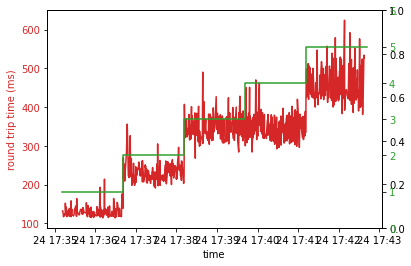

In [89]:
cpu_df = df.sample(n=1000).sort_values(by=['done'])
# RTT vs cpu
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('round trip time (ms)', color=color)
ax1.plot(cpu_df['done'], cpu_df['rtt'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('cpu utilization (%)', color=color)
# ax2.set_ylim(bottom=0, top=110)
# ax2.plot(cpu_df['done'], cpu_df['cpu'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# fig.tight_layout()
# plt.show()

concurrent_df = concurrent_req_log_as_df('/home/jp/Documents/GitProjects/traefik-results/stepped_small.log').loc[range(0, 5)]
concurrent_df = concurrent_df.append({ 'timestamp': concurrent_df.loc[4]['timestamp'] + pd.Timedelta("90s"), 'concurrent_clients': 5}, ignore_index=True)

# ax3 = ax1.twinx()
# ax3.plot(concurrent_df['timestamp'], concurrent_df['concurrent_clients'], color='tab:green')
# plt.show()

# https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

i = 0
lastval = 0
print(concurrent_df)
interpolated_df = concurrent_df.copy()
print(interpolated_df)
for index, row in concurrent_df.iterrows():
    if not i == 0:
        interpolated_df = interpolated_df.append({ "timestamp": row['timestamp'] - pd.Timedelta("1ns"), "concurrent_clients": lastval}, ignore_index=True)
    i += 1
    lastval = row['concurrent_clients']
interpolated_df = interpolated_df.sort_values(by=["timestamp"])
interpolated_df = interpolated_df.reset_index(drop=True)
# print(interpolated_df)

ax3 = ax1.twinx()
ax3.tick_params(axis='y', labelcolor='tab:green')
ax3.plot(interpolated_df['timestamp'], interpolated_df['concurrent_clients'], color='tab:green')
ax3.set_ylim(bottom=0, top=6)
plt.show()